# Models - Random Forest and Extra Trees

In [1]:
import pandas as pd

merged = pd.read_csv("../data/merged/trains_and_weather.csv") 
merged

/home/hdheli/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,commuterLineID,stationShortCode,commercialTrack,differenceInMinutes,weather_area,year,month,day,hour,categoryCode,categoryCodeId,detailedCategoryCode,detailedCategoryCodeId,direction,weekday,rain,celcius,windGustSpeed,windSpeed
0,A,LPV,4,0,2,2018,6,27,3,NaN,NaN,NaN,NaN,0,2,0,13,3,2
1,A,LPV,4,0,2,2018,6,27,3,NaN,NaN,NaN,NaN,0,2,0,13,3,2
2,A,LPV,4,0,2,2018,6,27,3,NaN,NaN,NaN,NaN,0,2,0,13,3,2
3,A,LPV,4,0,2,2018,6,27,3,NaN,NaN,NaN,NaN,0,2,0,13,3,2
4,A,LPV,4,0,2,2018,6,27,4,NaN,NaN,NaN,NaN,0,2,0,14,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10480658,Z,PSL,4,1,1,2017,9,2,20,NaN,NaN,NaN,NaN,1,5,0,12,4,3
10480659,Z,TKL,2,1,1,2017,9,2,20,NaN,NaN,NaN,NaN,1,5,0,12,4,3
10480660,Z,KE,4,1,1,2017,9,2,20,NaN,NaN,NaN,NaN,1,5,0,12,4,3
10480661,Z,HAA,4,0,1,2017,9,2,20,NaN,NaN,NaN,NaN,1,5,0,12,4,3


newest merged version 12.10.2020, floats converted to int, weekday added

In [2]:
df2 = merged.copy().drop(columns=["categoryCode","categoryCodeId","detailedCategoryCode","detailedCategoryCodeId", "commercialTrack"])


Changing the data to numeric, difference in minutes has been changed with this:


def get_category(x):
    if x<= 0:
        return 0
    if (x>0) & (x<3):
        return 1
    else:
        return 2

In [3]:
df3 = df2.copy().sample(2500000)
df3 = df3.astype({'commuterLineID': 'category', 'stationShortCode': 'category'})
categoryToNumeric = df3.select_dtypes(['category']).columns
df3[categoryToNumeric] = df3[categoryToNumeric].apply(lambda x: x.cat.codes)
df3.dtypes

commuterLineID          int8
stationShortCode        int8
differenceInMinutes    int64
weather_area           int64
year                   int64
month                  int64
day                    int64
hour                   int64
direction              int64
weekday                int64
rain                   int64
celcius                int64
windGustSpeed          int64
windSpeed              int64
dtype: object

### Save used sample to file

In [4]:
import datetime

now = '../data/samples/'+str(datetime.datetime.utcnow().isoformat(timespec="seconds"))+'Z.csv'
now
df3.to_csv(now)

### Try Tpot

In [6]:
df4 = df3.copy().sample(200000)

from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split

df4 = df4.dropna()

X_train, X_test, y_train, y_test = train_test_split(df4.drop("differenceInMinutes", axis=1), df4['differenceInMinutes'],
                                                    train_size=0.80, test_size=0.20, random_state=64)

X_train, X_test, y_train, y_test = train_test_split(df4.drop("differenceInMinutes", axis=1), df4['differenceInMinutes'],
                                                    train_size=0.80, test_size=0.20, random_state=64)
print(len(X_train))
tpot = TPOTClassifier(generations=3, population_size=35, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('../data/tpot_pipeline_200k.py')

160000



Generation 1 - Current best internal CV score: 0.63648125
Generation 2 - Current best internal CV score: 0.64100625
Generation 3 - Current best internal CV score: 0.64100625
Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=0.7000000000000001, min_samples_leaf=10, min_samples_split=8, n_estimators=100)
0.648375


### New Extra trees model 15.10.2020

In [6]:
import datetime
import pandas as pd

df5 = pd.read_csv("../data/samples/2020-10-14T13:25:59Z.csv") 
df5

,Unnamed: 0,commuterLineID,stationShortCode,differenceInMinutes,weather_area,year,month,day,hour,direction,weekday,rain,celcius,windGustSpeed,windSpeed
0,7667397,6,45,0,1,2019,9,13,20,1,4,0,8,6,4
1,1222405,9,8,1,1,2017,2,20,19,1,0,0,-1,4,3
2,9635053,3,51,0,1,2019,7,23,8,1,1,0,24,3,1
3,9383652,5,28,2,2,2017,9,6,22,1,2,0,9,6,3
4,3545988,9,19,0,2,2017,3,27,6,1,0,0,3,10,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499995,3938282,4,38,1,1,2019,2,11,14,0,0,0,0,1,0
2499996,8756245,6,38,0,1,2018,7,12,5,1,3,0,18,2,1
2499997,9519985,6,51,2,1,2017,11,3,20,1,4,0,1,4,4
2499998,682282,7,17,1,1,2019,12,14,5,1,5,0,2,9,6


In [7]:
from sklearn.ensemble import ExtraTreesClassifier
import sklearn
from sklearn.model_selection import train_test_split


X_train5, X_test5, y_train5, y_test5 = train_test_split(df5.drop("differenceInMinutes", axis=1), df5['differenceInMinutes'],
                                                    train_size=0.80, test_size=0.20, random_state=66)
et5 = ExtraTreesClassifier(bootstrap=False, criterion='gini', max_features=0.7000000000000001, min_samples_leaf=10, min_samples_split=8, n_estimators=100)

In [8]:
et5.fit(X_train5, y_train5)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None,
                     max_features=0.7000000000000001, max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=10,
                     min_samples_split=8, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=None, oob_score=False,
                     random_state=None, verbose=0, warm_start=False)

In [9]:
y_predtrain_et5 = et5.predict(X_train5)

train_error_et5 = sklearn.metrics.zero_one_loss(y_train5, y_predtrain_et5)
y_pred_et5 = et5.predict(X_test5)
test_error_et5 = sklearn.metrics.zero_one_loss(y_test5, y_pred_et5)

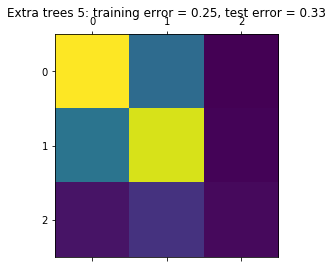

In [10]:
import matplotlib.pyplot as plt

plt.matshow(sklearn.metrics.confusion_matrix(y_test5, y_pred_et5))
plt.title("Extra trees 5: training error = %.2f, test error = %.2f" % (train_error_et5, test_error_et5))
plt.show()

In [11]:
from joblib import dump, load

model_path = '../data/ml-models/et'+str(datetime.datetime.utcnow().isoformat(timespec="seconds"))+'Z'
dump(et5, model_path) 

['../data/ml-models/et2020-10-15T06:56:39Z']

### Testing random forest model (15.10.2020)

Previously 100 trees used, which is the default setting

Lets try some other tree amounts, other parameters taken from extra trees recommendations

10 tree random forest prediction gives accuracy score: 0.65
20 tree random forest prediction gives accuracy score: 0.66
30 tree random forest prediction gives accuracy score: 0.66
40 tree random forest prediction gives accuracy score: 0.66
50 tree random forest prediction gives accuracy score: 0.66
60 tree random forest prediction gives accuracy score: 0.66
70 tree random forest prediction gives accuracy score: 0.66
80 tree random forest prediction gives accuracy score: 0.66
90 tree random forest prediction gives accuracy score: 0.66
100 tree random forest prediction gives accuracy score: 0.66
110 tree random forest prediction gives accuracy score: 0.66
120 tree random forest prediction gives accuracy score: 0.66
130 tree random forest prediction gives accuracy score: 0.66
140 tree random forest prediction gives accuracy score: 0.66
150 tree random forest prediction gives accuracy score: 0.66
160 tree random forest prediction gives accuracy score: 0.66
170 tree random forest prediction

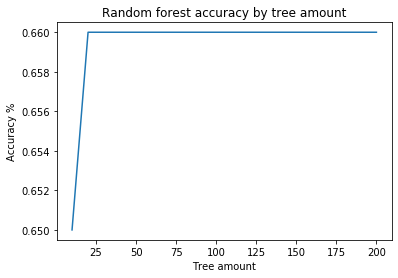

In [15]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# previously 100 trees used, default setting
def random_forest_analysis(X_train, X_test, y_train, y_test):
    train_vect = np.arange(10, 210, 10).tolist()
    result_x = []
    result_y = []
    for tree_amount in train_vect:
        model = RandomForestClassifier(n_estimators=tree_amount, max_features=0.70, criterion='gini', bootstrap=False,  min_samples_leaf=10, min_samples_split=8)
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        # print('Predictions:', prediction)
        # print('Expected:', y_test)
        accuracy = round(accuracy_score(y_test, prediction), 2)
        print(tree_amount, 'tree random forest prediction gives accuracy score:', accuracy)
        result_x.append(tree_amount)
        result_y.append(accuracy)
    plt.plot(result_x, result_y)
    plt.title("Random forest accuracy by tree amount")
    plt.xlabel("Tree amount")
    plt.ylabel("Accuracy %")
    plt.show()
    
random_forest_analysis(X_train5, X_test5, y_train5, y_test5)

### New rf6 model that is saved with 50 trees, 16.10.2020

In [17]:
        rf6 = RandomForestClassifier(n_estimators=50, max_features=0.70, criterion='gini', bootstrap=False,  min_samples_leaf=10, min_samples_split=8)
        rf6.fit(X_train5, y_train5)


NameError: name 'model' is not defined

In [18]:
        prediction6 = rf6.predict(X_test5)
        # print('Predictions:', prediction)
        # print('Expected:', y_test)
        accuracy6 = round(accuracy_score(y_test5, prediction6), 2)
        print('50 tree random forest prediction gives accuracy score:', accuracy6)

50 tree random forest prediction gives accuracy score: 0.66


In [19]:
from joblib import dump, load
model_path = '../data/ml-models/rf'+str(datetime.datetime.utcnow().isoformat(timespec="seconds"))+'Z'

dump(rf6, model_path) 

['../data/ml-models/rf2020-10-16T07:16:56Z']

Mallin koko taas iso 1.2 GB, mikä sen tekee?

In [21]:
rf7 = RandomForestClassifier(max_depth=12, n_estimators=50, max_features=0.70, criterion='gini', bootstrap=False,  min_samples_leaf=10, min_samples_split=8)
rf7.fit(X_train5, y_train5)



NameError: name 'prediction7' is not defined

In [22]:
prediction7 = rf7.predict(X_test5)
# print('Predictions:', prediction)
# print('Expected:', y_test)
accuracy7 = round(accuracy_score(y_test5, prediction7), 2)
print('50 tree random forest prediction max depth 12 gives accuracy score:', accuracy7)

model_path = '../data/ml-models/rf'+str(datetime.datetime.utcnow().isoformat(timespec="seconds"))+'Z'

dump(rf7, model_path) 

50 tree random forest prediction max depth 12 gives accuracy score: 0.63


['../data/ml-models/rf2020-10-16T08:27:55Z']

50 tree random forest prediction max depth 12 gives accuracy score: 0.63, file size 25.8 MB
10 max_depth, 50 tree, 2.5 milj row random forest prediction gives accuracy score: 0.61 ekalla

toka kierros:
10 max_depth, 50 tree, 2.5 milj row random forest prediction gives accuracy score: 0.6, file size 7.7 MB
11 max_depth, 50 tree, 2.5 milj row random forest prediction gives accuracy score: 0.62, file size 14.6 MB
12 max_depth, 50 tree, 2.5 milj row random forest prediction gives accuracy score: 0.63, file size 25.6 MB
13 max_depth, 50 tree, 2.5 milj row random forest prediction gives accuracy score: 0.64, file size 44 MB
14 max_depth, 50 tree, 2.5 milj row random forest prediction gives accuracy score: 0.65, file size 72.4 MB
15 max_depth, 50 tree, 2.5 milj row random forest prediction gives accuracy score: 0.65, file size 110.4 MB
16 max_depth, 50 tree, 2.5 milj row random forest prediction gives accuracy score: 0.65, file size 162 MB
17 max_depth, 50 tree, 2.5 milj row random forest prediction gives accuracy score: 0.66, file size 223.7 MB
18 max_depth, 50 tree, 2.5 milj row random forest prediction gives accuracy score: 0.66, file size 292.9 MB
19 max_depth, 50 tree, 2.5 milj row random forest prediction gives accuracy score: 0.66, file size 381.6 MB
20 max_depth, 50 tree, 2.5 milj row random forest prediction gives accuracy score: 0.66, file size 474.2 MB

Paras hyötysuhde 14 max_depth

11 max_depth, 50 tree, 2.5 milj row random forest prediction gives accuracy score: 0.62
12 max_depth, 50 tree, 2.5 milj row random forest prediction gives accuracy score: 0.63
13 max_depth, 50 tree, 2.5 milj row random forest prediction gives accuracy score: 0.64
14 max_depth, 50 tree, 2.5 milj row random forest prediction gives accuracy score: 0.65
15 max_depth, 50 tree, 2.5 milj row random forest prediction gives accuracy score: 0.65
16 max_depth, 50 tree, 2.5 milj row random forest prediction gives accuracy score: 0.65
17 max_depth, 50 tree, 2.5 milj row random forest prediction gives accuracy score: 0.66
18 max_depth, 50 tree, 2.5 milj row random forest prediction gives accuracy score: 0.66
19 max_depth, 50 tree, 2.5 milj row random forest prediction gives accuracy score: 0.66


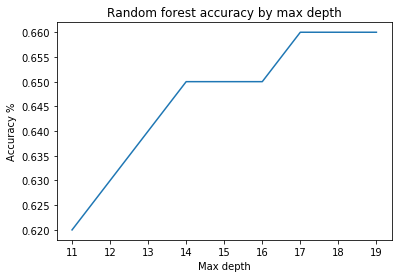

In [26]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# previously 100 trees used, default setting
def random_forest_analysis(X_train, X_test, y_train, y_test):
    train_vect = np.arange(11, 20, 1).tolist()
    result_x = []
    result_y = []
    for max_depth in train_vect:
        model = RandomForestClassifier(n_estimators=50, max_depth=max_depth, max_features=0.70, criterion='gini', bootstrap=False,  min_samples_leaf=10, min_samples_split=8)
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        # print('Predictions:', prediction)
        # print('Expected:', y_test)
        accuracy = round(accuracy_score(y_test, prediction), 2)
        print(max_depth, 'max_depth, 50 tree, 2.5 milj row random forest prediction gives accuracy score:', accuracy)
        result_x.append(max_depth)
        result_y.append(accuracy)
        model_path = f'../data/random-forest/rf-50tree-maxdepth-{max_depth}'
        dump(model, model_path) 
    plt.plot(result_x, result_y)
    plt.title("Random forest accuracy by max depth")
    plt.xlabel("Max depth")
    plt.ylabel("Accuracy %")
    plt.show()
    
random_forest_analysis(X_train5, X_test5, y_train5, y_test5)

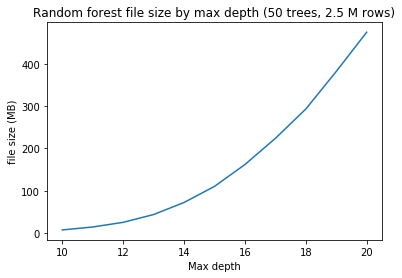

In [39]:
train_vect = np.arange(10, 21, 1).tolist()
file_sizes = [7.7, 14.6, 25.6, 44, 72.4, 110.4, 162, 223.7, 292.9, 381.6, 474.2]
plt.plot(train_vect, file_sizes)
plt.title("Random forest file size by max depth (50 trees, 2.5 M rows)")
plt.xlabel("Max depth")
plt.ylabel("file size (MB)")
plt.show()

### More rows rf8 random forest 8
5 milj rows, 50 trees, max depth 14


In [27]:
merged = pd.read_csv("../data/merged/trains_and_weather.csv") 
df8 = merged.copy().drop(columns=["categoryCode","categoryCodeId","detailedCategoryCode","detailedCategoryCodeId", "commercialTrack"])
df8 = df8.copy().sample(5000000)
df8 = df8.astype({'commuterLineID': 'category', 'stationShortCode': 'category'})
categoryToNumeric = df8.select_dtypes(['category']).columns
df8[categoryToNumeric] = df8[categoryToNumeric].apply(lambda x: x.cat.codes)
df8.dtypes


/home/hdheli/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


commuterLineID          int8
stationShortCode        int8
differenceInMinutes    int64
weather_area           int64
year                   int64
month                  int64
day                    int64
hour                   int64
direction              int64
weekday                int64
rain                   int64
celcius                int64
windGustSpeed          int64
windSpeed              int64
dtype: object

In [28]:
import datetime

now = '../data/samples/'+str(datetime.datetime.utcnow().isoformat(timespec="seconds"))+'Z.csv'
now
df8.to_csv(now)

In [29]:
import sklearn
from sklearn.model_selection import train_test_split


X_train8, X_test8, y_train8, y_test8 = train_test_split(df8.drop("differenceInMinutes", axis=1), df8['differenceInMinutes'],
                                                    train_size=0.80, test_size=0.20, random_state=66)

rf8 = RandomForestClassifier(max_depth=14, n_estimators=50, max_features=0.70, criterion='gini', bootstrap=False,  min_samples_leaf=10, min_samples_split=8)
rf8.fit(X_train8, y_train8)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features=0.7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

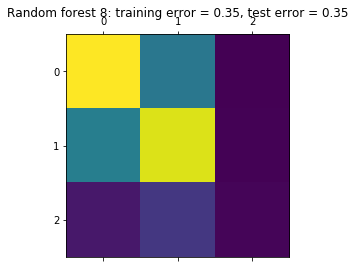

In [30]:
y_predtrain_rf8 = rf8.predict(X_train8)

train_error_rf8 = sklearn.metrics.zero_one_loss(y_train8, y_predtrain_rf8)
y_pred_rf8 = rf8.predict(X_test8)
test_error_rf8 = sklearn.metrics.zero_one_loss(y_test8, y_pred_rf8)
y_predtrain_rf8 = rf8.predict(X_train8)

train_error_rf8 = sklearn.metrics.zero_one_loss(y_train8, y_predtrain_rf8)
y_pred_rf8 = rf8.predict(X_test8)
test_error_rf8 = sklearn.metrics.zero_one_loss(y_test8, y_pred_rf8)
import matplotlib.pyplot as plt

plt.matshow(sklearn.metrics.confusion_matrix(y_test8, y_pred_rf8))
plt.title("Random forest 8: training error = %.2f, test error = %.2f" % (train_error_rf8, test_error_rf8))
plt.show()


In [31]:
model_path = f'../data/random-forest/rf-50tree-maxdepth14-5miljrows'
dump(rf8, model_path) 

['../data/random-forest/rf-50tree-maxdepth14-5miljrows']

random forest: data 5 milj rows, 50 trees, 14 max depth, accuracy 0.65, file size 85.6 MB

### Random forest 9: all in - use all data. 50 trees, 14 max depth

In [32]:
merged = pd.read_csv("../data/merged/trains_and_weather.csv") 
df9 = merged.copy().drop(columns=["categoryCode","categoryCodeId","detailedCategoryCode","detailedCategoryCodeId", "commercialTrack"])
df9 = df9.astype({'commuterLineID': 'category', 'stationShortCode': 'category'})
categoryToNumeric = df9.select_dtypes(['category']).columns
df9[categoryToNumeric] = df9[categoryToNumeric].apply(lambda x: x.cat.codes)
df9.dtypes


/home/hdheli/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


commuterLineID          int8
stationShortCode        int8
differenceInMinutes    int64
weather_area           int64
year                   int64
month                  int64
day                    int64
hour                   int64
direction              int64
weekday                int64
rain                   int64
celcius                int64
windGustSpeed          int64
windSpeed              int64
dtype: object

In [33]:
import datetime

now = '../data/samples/'+str(datetime.datetime.utcnow().isoformat(timespec="seconds"))+'Z.csv'
now
df9.to_csv(now)

In [34]:
import sklearn
from sklearn.model_selection import train_test_split


X_train9, X_test9, y_train9, y_test9 = train_test_split(df9.drop("differenceInMinutes", axis=1), df9['differenceInMinutes'],
                                                    train_size=0.80, test_size=0.20, random_state=66)

rf9 = RandomForestClassifier(max_depth=14, n_estimators=50, max_features=0.70, criterion='gini', bootstrap=False,  min_samples_leaf=10, min_samples_split=8)
rf9.fit(X_train9, y_train9)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features=0.7,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

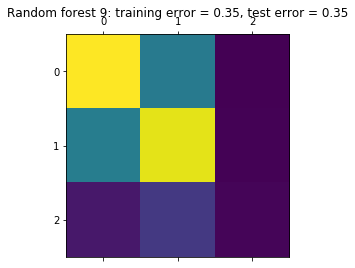

In [35]:
y_predtrain_rf9 = rf9.predict(X_train9)

train_error_rf9 = sklearn.metrics.zero_one_loss(y_train9, y_predtrain_rf9)
y_pred_rf9 = rf9.predict(X_test9)
test_error_rf9 = sklearn.metrics.zero_one_loss(y_test9, y_pred_rf9)
y_predtrain_rf9 = rf9.predict(X_train9)

train_error_rf9 = sklearn.metrics.zero_one_loss(y_train9, y_predtrain_rf9)
y_pred_rf9 = rf9.predict(X_test9)
test_error_rf9 = sklearn.metrics.zero_one_loss(y_test9, y_pred_rf9)
import matplotlib.pyplot as plt

plt.matshow(sklearn.metrics.confusion_matrix(y_test9, y_pred_rf9))
plt.title("Random forest 9: training error = %.2f, test error = %.2f" % (train_error_rf9, test_error_rf9))
plt.show()

In [36]:
model_path = f'../data/random-forest/rf-50tree-maxdepth14-alldata'
dump(rf9, model_path) 

['../data/random-forest/rf-50tree-maxdepth14-alldata']

random forest: data all rows, 50 trees, 14 max depth, accuracy 0.65, file size 96.9 MB

### Make the model (old ones)

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df3.drop("differenceInMinutes", axis=1), df3['differenceInMinutes'],
                                                    train_size=0.80, test_size=0.20, random_state=66)

rf3 = RandomForestClassifier(max_depth=12, random_state=66, n_estimators=100)
rf3.fit(X_train, y_train)
y_predtrain_rf3 = rf3.predict(X_train)


NameError: name 'sklearn' is not defined

In [1]:
import sklearn

train_error_rf3 = sklearn.metrics.zero_one_loss(y_train, y_predtrain_rf3)
y_pred_rf3 = rf3.predict(X_test)
test_error_rf3 = sklearn.metrics.zero_one_loss(y_test, y_pred_rf3)


AttributeError: module 'sklearn' has no attribute 'metrics'

### Plot confusion matrix

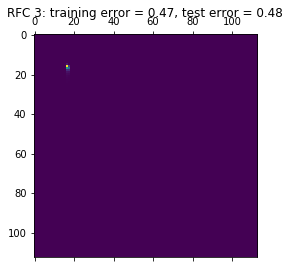

In [24]:
import matplotlib.pyplot as plt

plt.matshow(sklearn.metrics.confusion_matrix(y_test, y_pred_rf3))
plt.title("RFC 3: training error = %.2f, test error = %.2f" % (train_error_rf3, test_error_rf3))
plt.show()

### Save the model

In [25]:
from joblib import dump, load
model_path = '../data/ml-models/rf'+str(datetime.datetime.utcnow().isoformat(timespec="seconds"))+'Z'

dump(rf3, model_path) 

['../ml-models/rf2020-10-01T13:16:42Z.csv']

### Make another model: ExtraTreesClassifier

Recommeded by Tpot as the Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=True, criterion=gini, max_features=0.9000000000000001, min_samples_leaf=5, min_samples_split=12, n_estimators=100)
0.7155349051975411

Changing the data to numeric. As the model fitting crashes if minutes are used as they are, I convert them to classes:

0 = (minutes <= 0)
1 = (0 < minutes < 3)
2 = (3 <= minutes < 5)
3 = (5 <= minutes < 10)
4 = (10 <= minutes < 20)
5 = (20 <= minutes < 30)
6 = (30 <= minutes)


In [5]:
# Getting a new sample
df4 = df2.copy().sample(2000000)
df4 = df4.dropna()
df4 = df4.astype({'commuterLineID': 'category', 'stationShortCode': 'category'})
categoryToNumeric = df4.select_dtypes(['category']).columns
df4[categoryToNumeric] = df4[categoryToNumeric].apply(lambda x: x.cat.codes)
df4.dtypes

commuterLineID            int8
stationShortCode          int8
differenceInMinutes    float64
weather_area             int64
year                     int64
month                    int64
day                      int64
hour                     int64
direction                int64
rain                   float64
celcius                float64
windGustSpeed          float64
windSpeed              float64
dtype: object

In [16]:
# vlass devide is already done in the merge now
def minutes_to_classes(minutes):
    if minutes <= 0:
        return 0
    elif ((0 < minutes) & (minutes< 3)):
        return 1
    elif ((3 <= minutes) & (minutes < 5)):
        return 2
    elif ((5 <= minutes) & (minutes < 10)):
        return 3
    elif ((10 <= minutes) & (minutes < 20)):
        return 4
    elif ((20 <= minutes)&(minutes < 30)):
        return 5
    else:
        return 6
        
df4['differenceMinsClasses'] =  df4['differenceInMinutes'].apply(lambda x: minutes_to_classes(x)) 
df4 = df4.drop("differenceInMinutes", axis=1)

In [17]:
import datetime
now = '../data/samples/'+str(datetime.datetime.utcnow().isoformat(timespec="seconds"))+'Z.csv'
now
df4.to_csv(now)
df4

,commuterLineID,stationShortCode,weather_area,year,month,day,hour,direction,rain,celcius,windGustSpeed,windSpeed,differenceMinsClasses
1745093,2,35,2,2019,12,31,16,0,0.0,0.1,11.6,7.7,0
10355112,7,0,1,2017,12,1,15,0,0.4,-0.3,9.6,5.8,2
6504334,9,63,2,2018,6,18,17,1,0.0,16.9,11.5,7.3,1
7014555,3,60,1,2018,7,11,14,0,0.0,21.7,4.2,2.1,0
1659977,3,31,1,2019,1,29,17,1,0.0,-5.0,5.2,3.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6916025,3,16,1,2017,6,25,5,1,0.0,13.6,5.2,3.4,0
2485120,3,68,1,2019,2,25,14,1,0.0,6.3,11.2,7.2,0
3570650,6,34,1,2019,8,9,15,1,0.0,22.0,5.3,3.4,0
9751403,11,3,1,2018,4,15,13,1,0.0,11.9,5.3,3.9,1


In [18]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split

X_train4, X_test4, y_train4, y_test4 = train_test_split(df4.drop("differenceMinsClasses", axis=1), df4['differenceMinsClasses'],
                                                    train_size=0.80, test_size=0.20, random_state=66)
et4 = ExtraTreesClassifier(bootstrap=True, criterion='gini', max_features=0.9000000000000001, min_samples_leaf=5, min_samples_split=12, n_estimators=100)

### Fitting the model

In [19]:
import sklearn

et4.fit(X_train4, y_train4)

ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None,
                     max_features=0.9000000000000001, max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=5,
                     min_samples_split=12, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=None, oob_score=False,
                     random_state=None, verbose=0, warm_start=False)

In [20]:
y_predtrain_et4 = et4.predict(X_train4)

train_error_et4 = sklearn.metrics.zero_one_loss(y_train4, y_predtrain_et4)
y_pred_et4 = et4.predict(X_test4)
test_error_et4 = sklearn.metrics.zero_one_loss(y_test4, y_pred_et4)

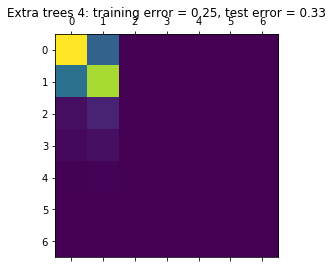

In [21]:
import matplotlib.pyplot as plt

plt.matshow(sklearn.metrics.confusion_matrix(y_test4, y_pred_et4))
plt.title("Extra trees 4: training error = %.2f, test error = %.2f" % (train_error_et4, test_error_et4))
plt.show()

### Save the model

In [22]:
from joblib import dump, load

model_path = '../data/ml-models/et'+str(datetime.datetime.utcnow().isoformat(timespec="seconds"))+'Z'
dump(et4, model_path) 

['../data/ml-models/et2020-10-02T17:26:40Z']